In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
# from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load images

In [5]:
filefolder = '../../data2024/processed/00-images/'

###################
# BACKGROUND FILE #
###################

filename_B = filefolder + 'ER-img/out-img75/'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = filefolder + 'mDM' + str(mDM) + 'GeV-img/out-img75/'

In [6]:
from keras import backend as K
np.random.seed(0)

# Define recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##### TEST-VAL SET

In [8]:
# test
from PIL import Image

for i in range(2):
    img = Image.open( filename_S + 'WP' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)
    
for i in range(2):
    img = Image.open( filename_B + 'ER' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)

(75, 75, 4)
(75, 75, 4)
(75, 75, 4)
(75, 75, 4)


In [11]:
##########
# SIGNAL #
##########
num_signal = 10000

file_pathsWP = glob.glob(path.join(filename_S, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal)


##############
# BACKGROUND #
##############
num_back = 10000

file_pathsER = glob.glob(path.join(filename_B, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back)



images = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER



print('images.shape: ', images.shape)
print('labels.shape: ', labels.shape)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

# Scale images so values are between 0 and 1
images = images / 255

n_images = images.shape[0]

images.shape:  (20000, 75, 75, 4)
labels.shape:  (20000,)
[75 75  4]


In [12]:
# Split into test and training sets

TRAIN_TEST_SPLIT = 0.7            

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_val = images[test_indices, :, :, :]
y_val = labels[test_indices]

#x_train = images
#y_train = labels

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(14000, 75, 75, 4)
(14000,)
(6000, 75, 75, 4)
(6000,)


##### TRAIN THE MODEL

In [22]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (image_size[0], image_size[1], image_size[2])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

# def run_CNN():
model = CNN_model()
model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=1, validation_data=(x_val, y_val))
#model.save(model_name)
#model.save_weights('final_weights.h5')
score = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test f1:', score[2])
print('Test precision:', score[3])
print('Test recall:', score[4])

# run_CNN()

Epoch 1/50
140/140 [==============================] - 15s 103ms/step - loss: 1.8174 - acc: 0.5820 - f1_m: 0.5841 - precision_m: 0.5814 - recall_m: 0.6379 - val_loss: 0.6075 - val_acc: 0.7622 - val_f1_m: 0.7537 - val_precision_m: 0.7862 - val_recall_m: 0.7272
Epoch 2/50
140/140 [==============================] - 15s 104ms/step - loss: 0.6113 - acc: 0.7562 - f1_m: 0.7614 - precision_m: 0.7470 - recall_m: 0.7841 - val_loss: 0.5730 - val_acc: 0.7815 - val_f1_m: 0.7688 - val_precision_m: 0.8209 - val_recall_m: 0.7258
Epoch 3/50
140/140 [==============================] - 15s 104ms/step - loss: 0.5782 - acc: 0.7774 - f1_m: 0.7738 - precision_m: 0.7800 - recall_m: 0.7783 - val_loss: 0.5369 - val_acc: 0.8018 - val_f1_m: 0.8113 - val_precision_m: 0.7769 - val_recall_m: 0.8519
Epoch 4/50
140/140 [==============================] - 15s 105ms/step - loss: 0.5661 - acc: 0.7798 - f1_m: 0.7783 - precision_m: 0.7801 - recall_m: 0.7869 - val_loss: 0.5355 - val_acc: 0.8043 - val_f1_m: 0.8020 - val_precisi

140/140 [==============================] - 14s 103ms/step - loss: 0.4996 - acc: 0.8232 - f1_m: 0.8203 - precision_m: 0.8169 - recall_m: 0.8313 - val_loss: 0.4986 - val_acc: 0.8178 - val_f1_m: 0.8142 - val_precision_m: 0.8360 - val_recall_m: 0.7961
Epoch 33/50
140/140 [==============================] - 14s 103ms/step - loss: 0.4953 - acc: 0.8234 - f1_m: 0.8238 - precision_m: 0.8116 - recall_m: 0.8422 - val_loss: 0.5206 - val_acc: 0.8167 - val_f1_m: 0.8336 - val_precision_m: 0.7664 - val_recall_m: 0.9173
Epoch 34/50
140/140 [==============================] - 15s 104ms/step - loss: 0.5234 - acc: 0.8134 - f1_m: 0.8145 - precision_m: 0.7992 - recall_m: 0.8383 - val_loss: 0.4888 - val_acc: 0.8298 - val_f1_m: 0.8334 - val_precision_m: 0.8213 - val_recall_m: 0.8486
Epoch 35/50
140/140 [==============================] - 14s 102ms/step - loss: 0.5272 - acc: 0.8151 - f1_m: 0.8139 - precision_m: 0.8087 - recall_m: 0.8305 - val_loss: 0.5065 - val_acc: 0.8227 - val_f1_m: 0.8221 - val_precision_m: 0.

##### TESTSET

In [23]:
##########
# SIGNAL #
##########
num_signal_test = 5000

file_pathsWP = glob.glob(path.join(filename_S, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal,num_signal+num_signal_test)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal_test)


##############
# BACKGROUND #
##############
num_back_test = 5000

file_pathsER = glob.glob(path.join(filename_B, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back,num_back+num_back_test)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back_test)



images_test = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels_test = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER


print('images_test.shape: ', images_test.shape)
print('labels_test.shape: ', labels_test.shape)

# Get image size
image_size_test = np.asarray([images_test.shape[1], images_test.shape[2], images_test.shape[3]])
print(image_size_test)

# Scale images so values are between 0 and 1
images_test = images_test / 255

n_images_test = images_test.shape[0]



x_test = images_test
del images_test

y_test = labels_test
del labels_test

images_test.shape:  (10000, 75, 75, 4)
labels_test.shape:  (10000,)
[75 75  4]


313/313 [==============================] - 2s 7ms/step - loss: 0.5025 - acc: 0.8288 - f1_m: 0.4682 - precision_m: 0.5001 - recall_m: 0.4415
acc: 82.88%


/home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.837 auc=0.9058808


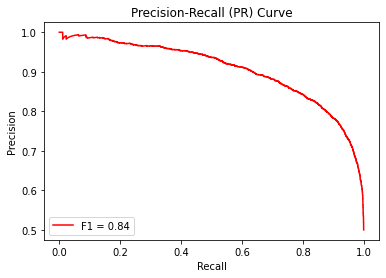

Accuracy: 0.8288
Average precision: 0.7624317736670294
recall: 0.8802
AUC:0.8691250816104462
Predicted   0.0   1.0
Actual               
0.0        3887  1113
1.0         599  4401


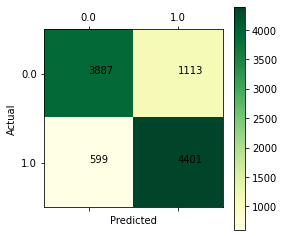

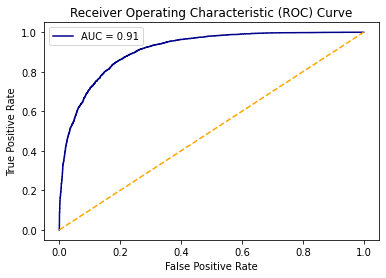

ROC AUC:  0.91178416


In [24]:
##########################
# TEST WITH THE TEST SET #
##########################

# dependencies = {
#     'f1_m' : f1_m, 
#     'precision_m' : precision_m,
#     'recall_m': recall_m,
# }

# model = keras.models.load_model(model_name, custom_objects=dependencies)

# model.summary()



score = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test)    # Predict probabilities
yhat = model.predict(x_test)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

##### Test with the train set (just to see)

In [25]:
##################################
# USING TO TEST THE TRAINING SET # THIS IS WRONG! but to see
##################################

x_test2 = images
y_test2 = labels

625/625 [==============================] - 4s 7ms/step - loss: 0.4886 - acc: 0.8349 - f1_m: 0.4697 - precision_m: 0.5005 - recall_m: 0.4434
acc: 83.49%


/home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.843 auc=0.9183301


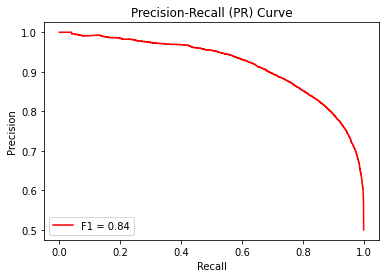

Accuracy: 0.83485
Average precision: 0.7692915599164168
recall: 0.8852
AUC:0.8734077496138821
Predicted   0.0   1.0
Actual               
0.0        7845  2155
1.0        1148  8852


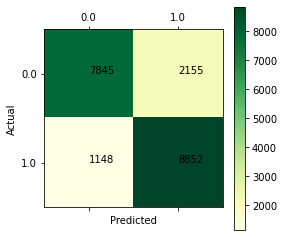

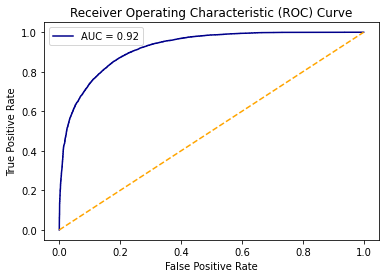

ROC AUC:  0.9214449


In [26]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

# dependencies = {
#     'f1_m' : f1_m, 
#     'precision_m' : precision_m,
#     'recall_m': recall_m,
# }

# model = keras.models.load_model(model_name, custom_objects=dependencies)

# model.summary()



score = model.evaluate(x_test2, y_test2, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test2)    # Predict probabilities
yhat = model.predict(x_test2)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test2, lr_probs)
lr_f1, lr_auc = f1_score(y_test2, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test2, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test2, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test2, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test2, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test2.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test2, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)